# ioniq demo

### The notebook is designed to demonstrate the analysis of nanopore ionic current data.

In [3]:
# Import lobraries and modules
import ioniq.core as ct
from ioniq.io import EDHReader, XMLReader
from ioniq.parsers import SpeedyStatSplit
from ioniq.parsers import NoiseFilterParser
import ioniq.datatypes as dt
from ioniq.parsers import SpikeParser
import os
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import inspect
from scipy.signal import find_peaks
import xml.etree.ElementTree as ET
from IPython.display import Markdown, display
! pip install pyqt6
from ioniq.utils import Trimmer, Filter


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from importlib import reload
import ioniq.io
reload(ioniq.io)
from ioniq.io import XMLReader

## Upload files

#### in this demo we focus on the Axopatch output XML files with timestamps, voltages, and corresponding opt files with the current data

In [5]:
# Provide the path to the input XML file
# file 1 has a triangle waveform
xml_file_1 = "/Users/dinaraboyko/grad_school/cloned_repo/data/TOKW/B090624SR_100kHz__000.xml"
# file 2, 3 are from Xialin's experiments
xml_file_2 = "/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__006.xml"
xml_file_3 = "/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__008.xml"
# List of files
datafiles_voltage = [xml_file_1, xml_file_2, xml_file_3]

In [6]:
datafiles=glob.glob('/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/*/*.xml')[1:]
print(*datafiles,sep='\n')

/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__004.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__006.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__003.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__008.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__011.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__012.xml
/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__013.xml


# Observe xml file current and voltage. Raw data

## Plot the current against the time with an aligned voltage
### Plots for different voltage protocols


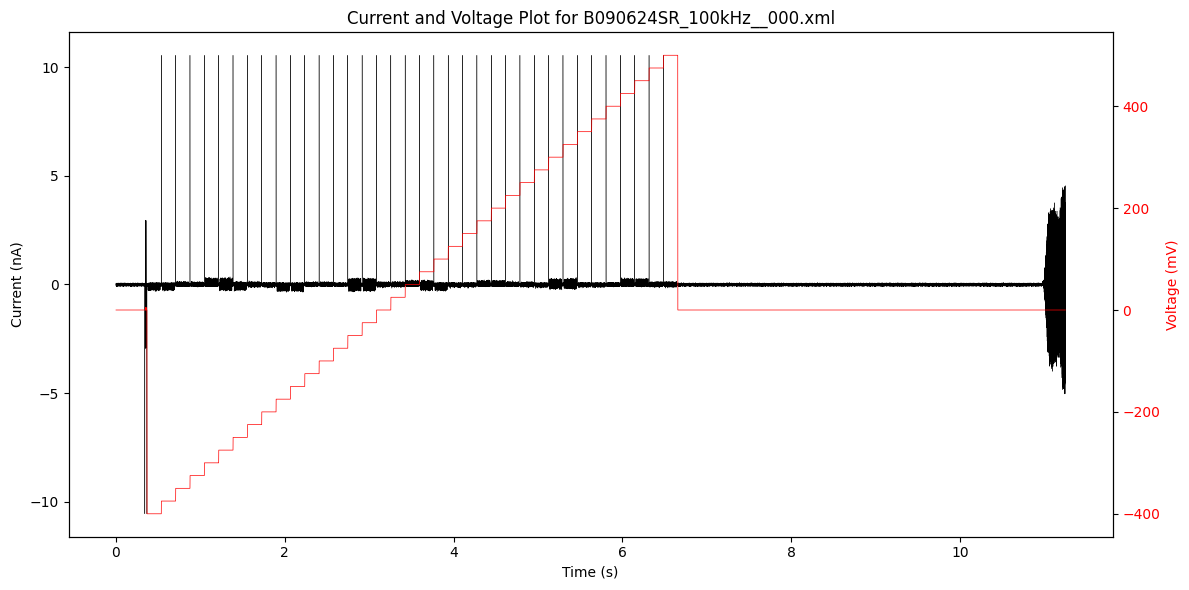

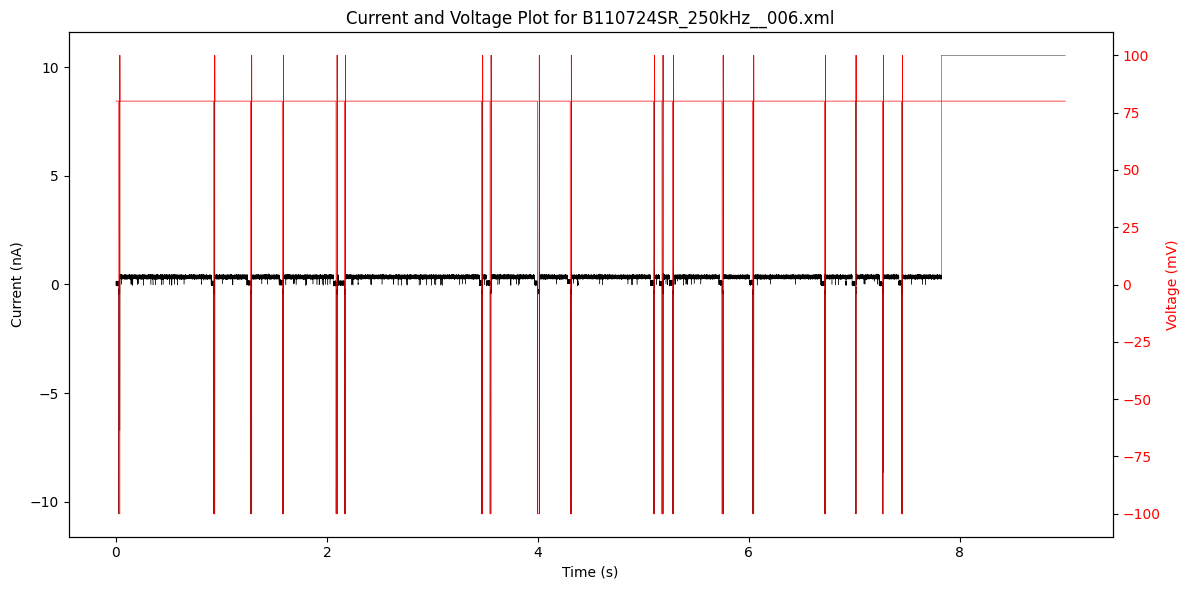

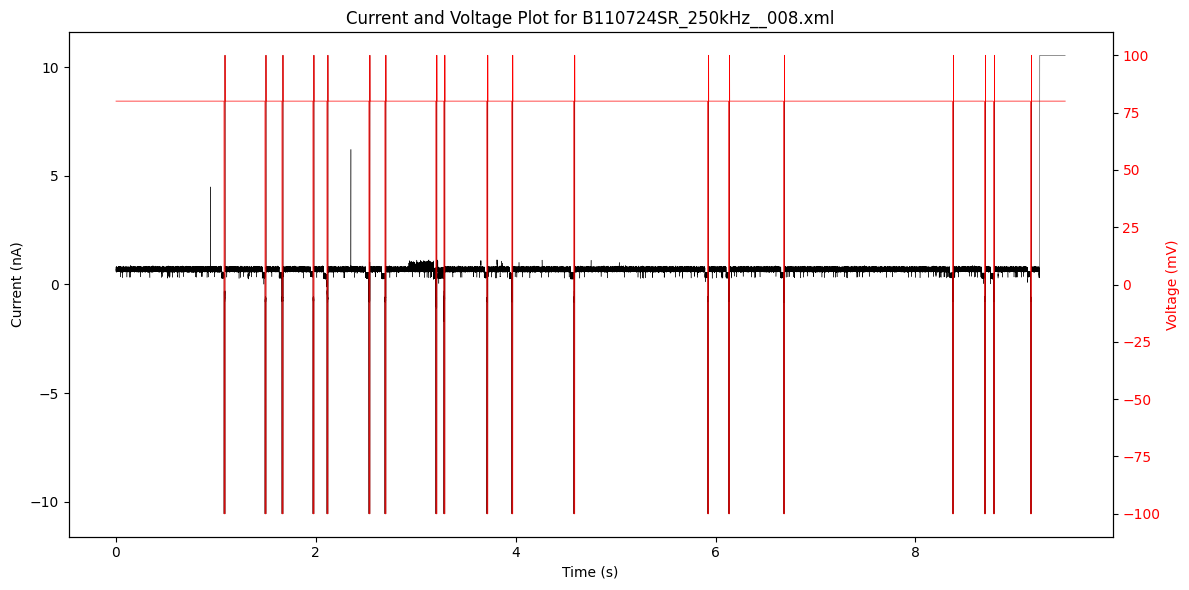

In [7]:
%matplotlib inline
for file in datafiles_voltage:
    metadata, current, voltage = XMLReader(file, voltage_compress=True, downsample=10)
    voltage_data = voltage
    current_sliced = current[:metadata["total_samples"]]
    sampling_frequency = metadata['Sampling frequency (SR)']
    time = np.linspace(0, len(current) / sampling_frequency, num=len(current))
    
    voltage_ = np.zeros(len(current))
    for (start, end), value in voltage_data:
        voltage_[start:end] = value
    
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    
    ax1.plot(time, current, lw=0.3, c='k', label='Current')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Current (nA)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    
    ax2 = ax1.twinx()
    ax2.plot(time, voltage_, lw=0.5, c='r', label='Voltage')
    ax2.set_ylabel('Voltage (mV)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    file_name = metadata["HeaderFile"].split("/")[-1]
    plt.title(f"Current and Voltage Plot for {file_name}")
    plt.tight_layout()
    plt.show()


# Observe preprocessed files

## Extract metadata, current and voltage from the input file with the parameters:

*voltage_compress* is a boolean parameter.
* True voltage data is compressed and represented in a summarized format (list of start and end points for each voltage step)
* False voltage is a full array

*downsample* is the factor by which the data is downsampled. 
* downsample=1: all data points are preserved.
* downsample=10: every 10th data point is retained, reducing data size.

*prefilter*: apply the following filters of on the data: 

* Low-pass filters: Remove high-frequency noise.
* High-pass filters: Remove baseline drifts or low-frequency artifacts.
* Band-pass filters: Retain a specific frequency range for analysis.
* Band-stop filters:

  define the method:
  filter_method:

  * butter, bessel


In [8]:
# Initialize Filter
reload(ioniq.utils)
from ioniq.utils import Trimmer, Filter
cutoff_frequency = 25000
filter_type = "lowpass"
filter_method = "bessel"
order = 2
bidirectional = True
sampling_frequency = 250000


filt = Filter(
    cutoff_frequency=cutoff_frequency,
    filter_type='lowpass',
    filter_method = filter_method,
    bidirectional=bidirectional,
    sampling_frequency=sampling_frequency
)
trimmer=Trimmer(samples_to_remove=100)

In [16]:
# Apply filters
sfm = dt.SessionFileManager()
sfm.clear_children()
for datafile in datafiles:
    metadata, current, voltage = XMLReader(datafile, voltage_compress=True, downsample=5, prefilter=filt)
    trace_file = dt.TraceFile(current=current, voltage=voltage, parent=sfm, metadata=metadata, unique_features={"sampling_freq": metadata["eff_sampling_freq"]})
    trimmer(trace_file)

## Conductance plot

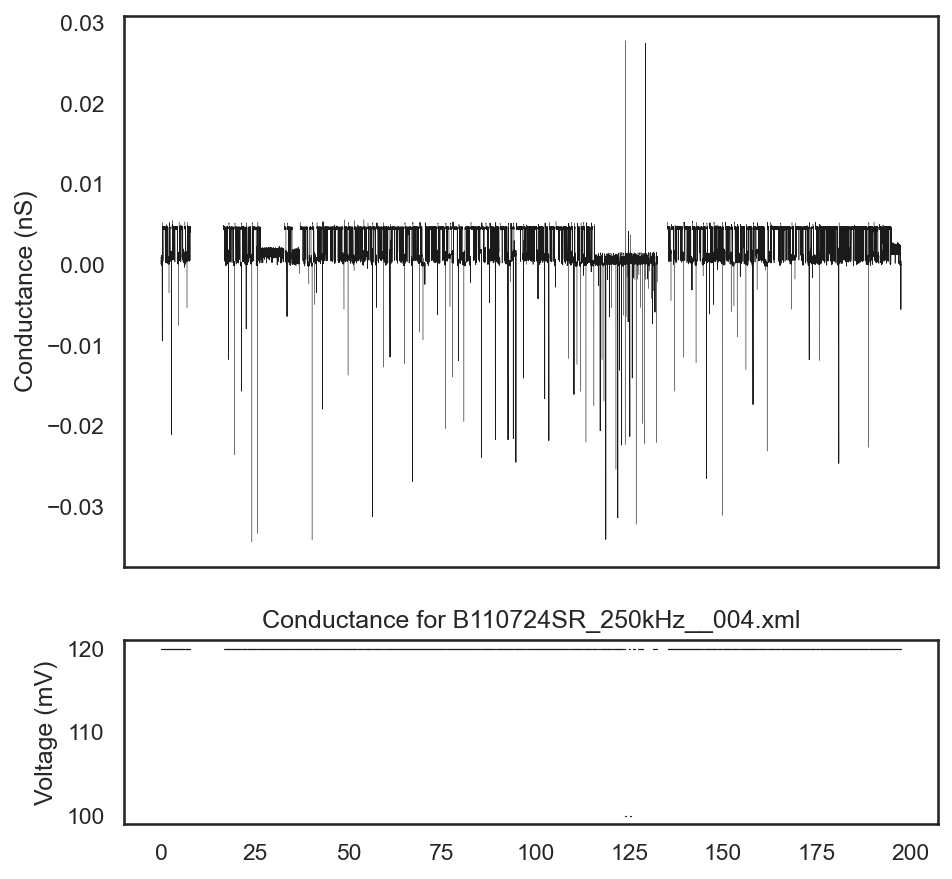

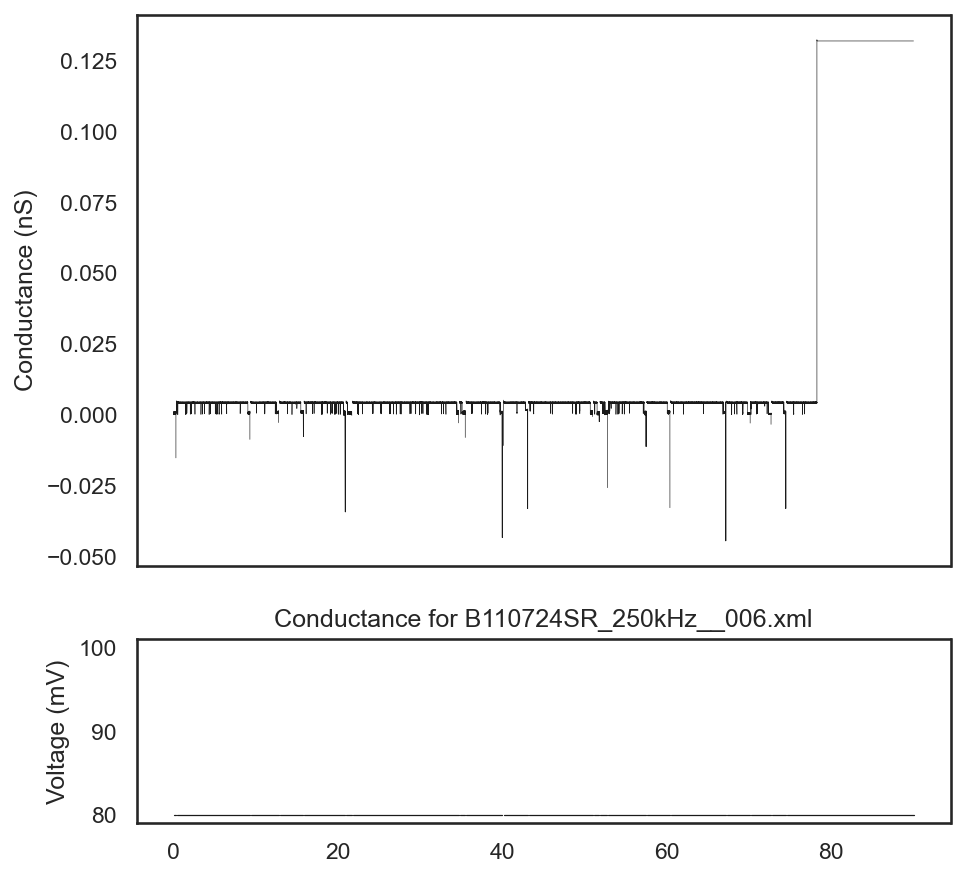

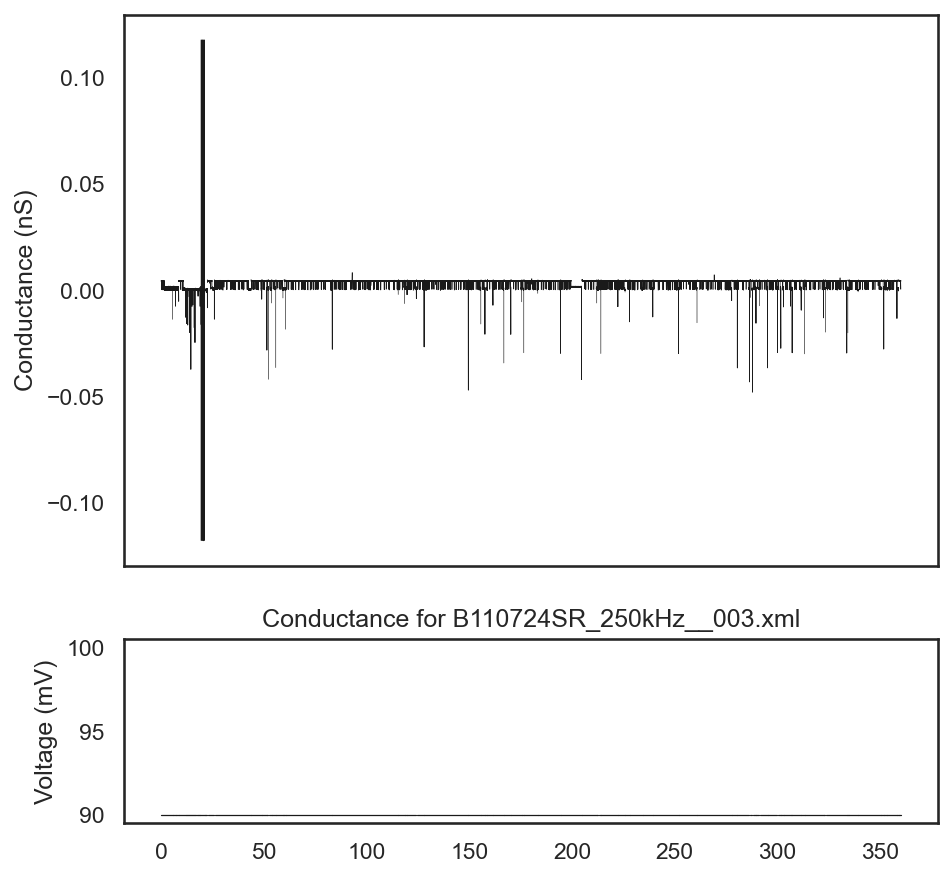

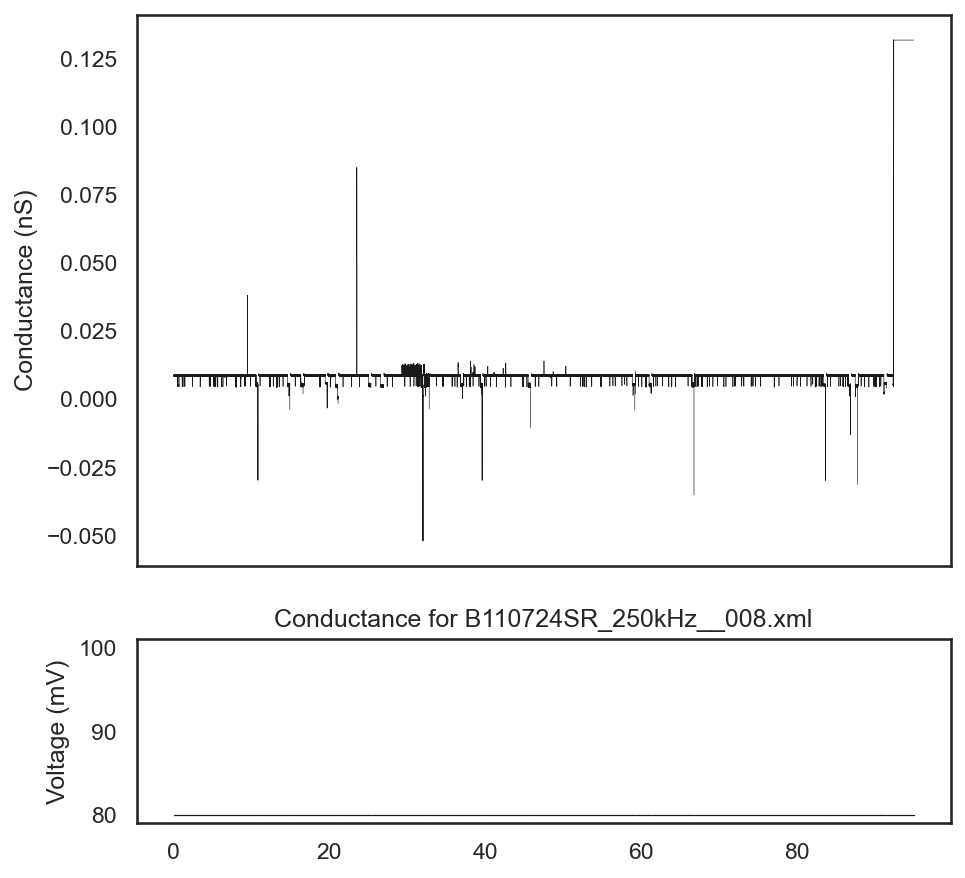

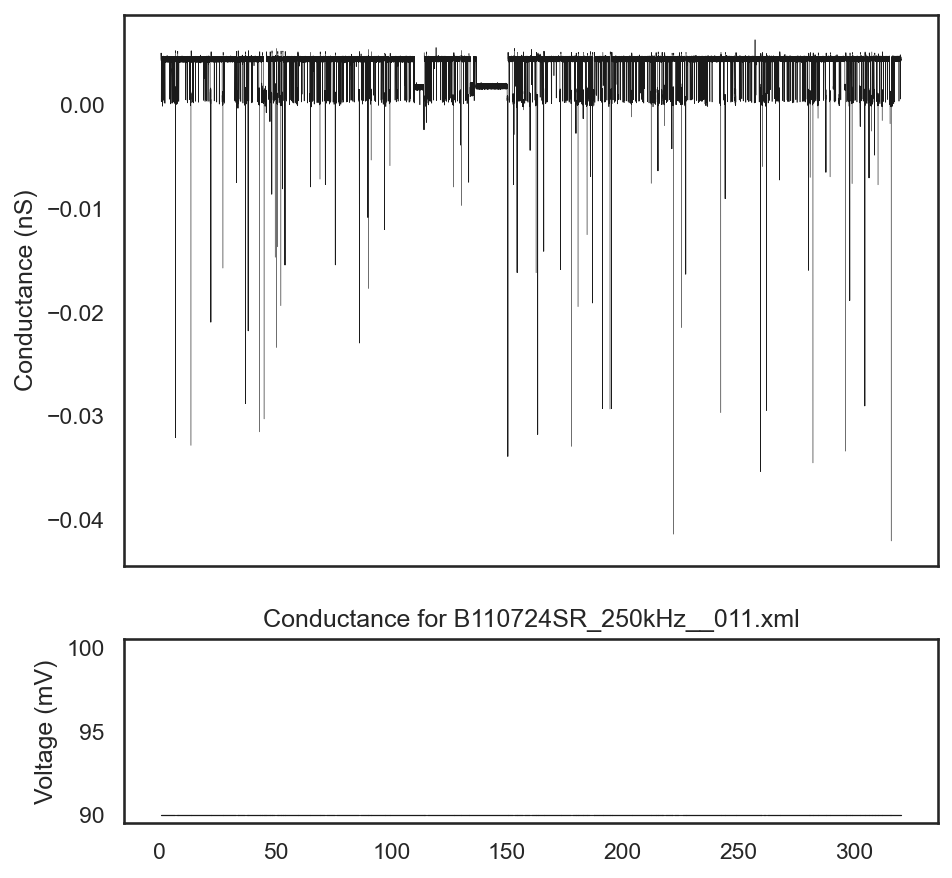

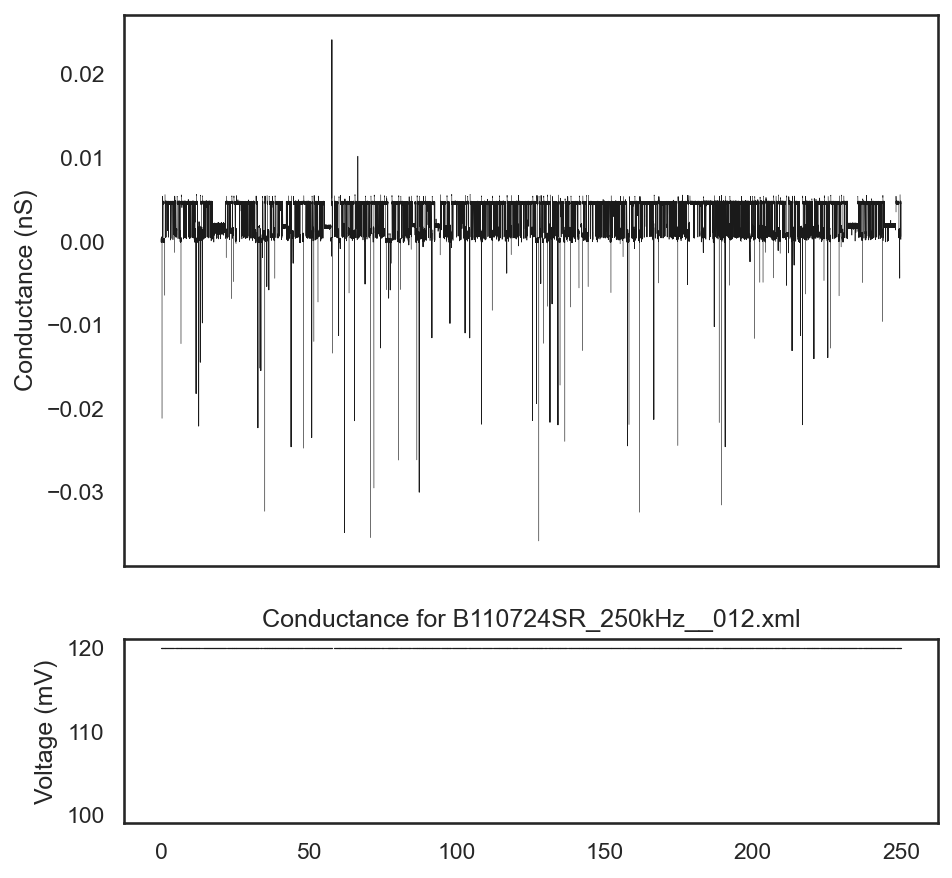

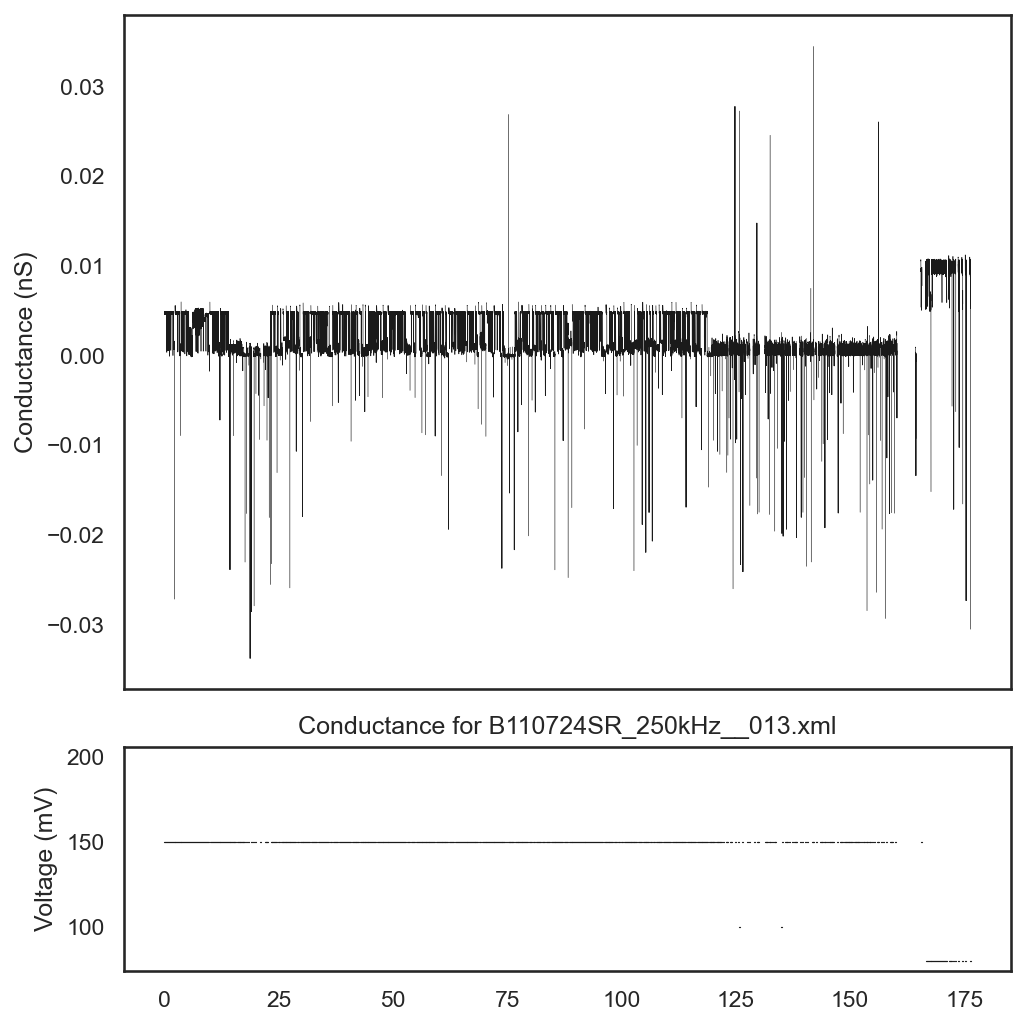

In [17]:
 # Conductance in nS
%matplotlib inline
for i, tf in enumerate(sfm.children):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, num=i+1, 
                                   gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 7))
    for child in tf.traverse_to_rank("vstepgap"):
        voltage = child.get_feature("voltage")
        if voltage > 0:  
            conductance = child.current  / voltage 
            ax0.plot(child.time, conductance, lw=0.3, c='k') 
            ax1.plot([child.time[0], child.time[-1]], [voltage] * 2, lw=0.6, c='k')
    file_name = tf.get_feature("metadata")["HeaderFile"].split("/")[-1]
    plt.title(f"Conductance for {file_name}")
    ax0.set_ylabel("Conductance (nS)")
    ax1.set_ylabel("Voltage (mV)")
plt.tight_layout()
plt.show()

## Curent and voltage steps

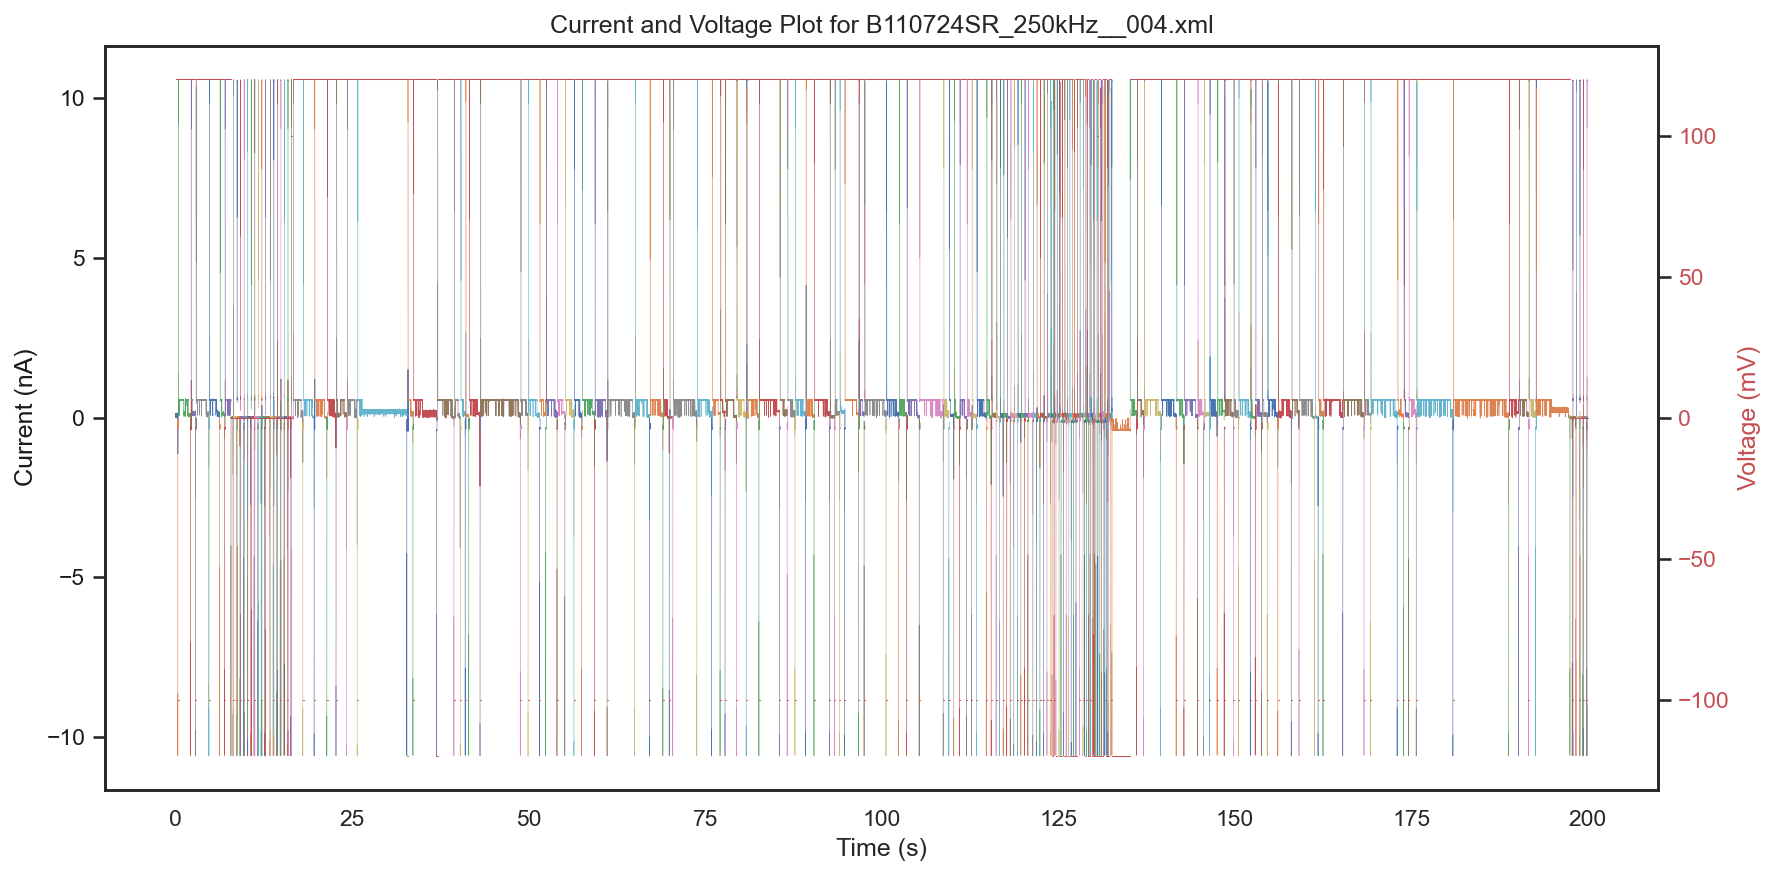

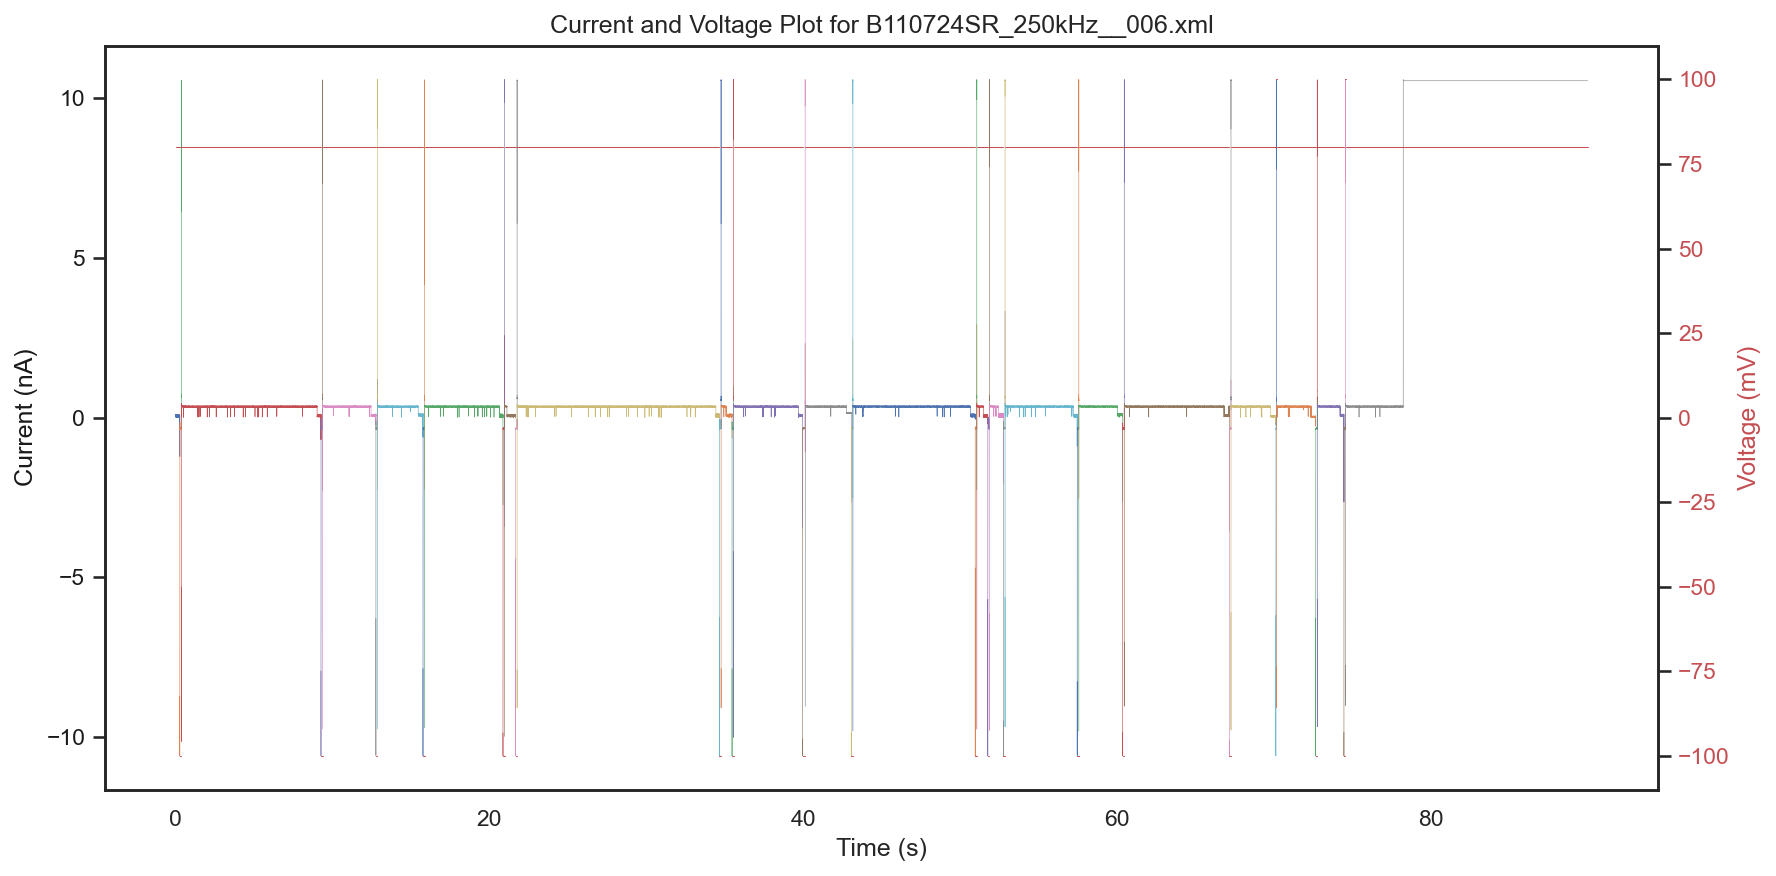

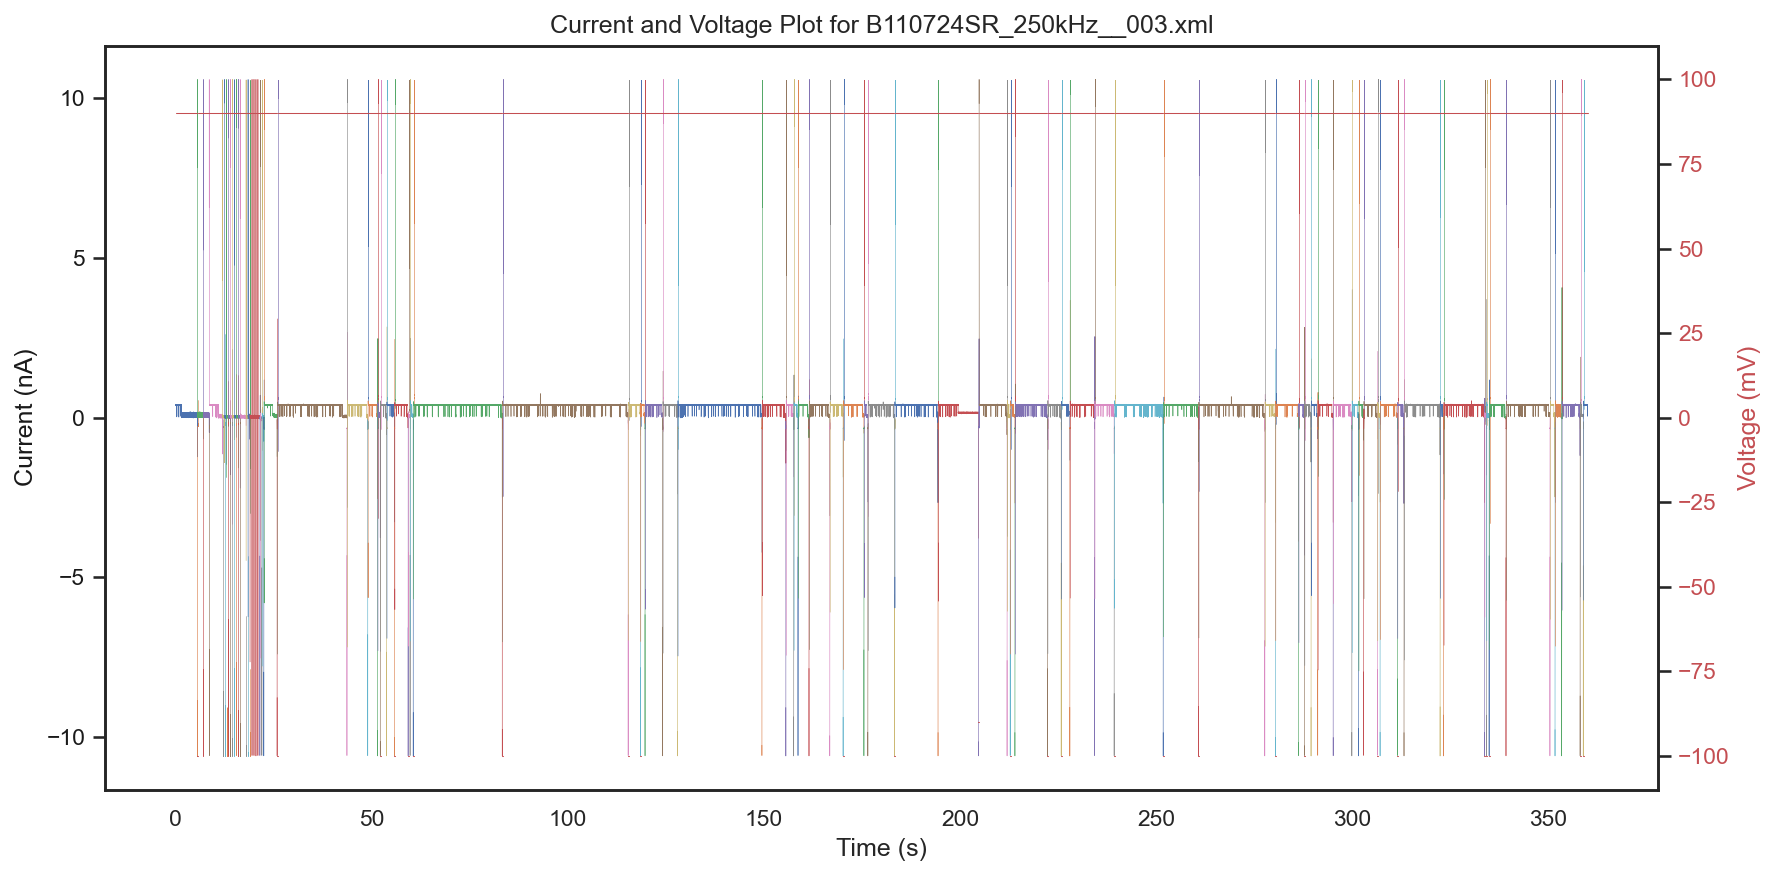

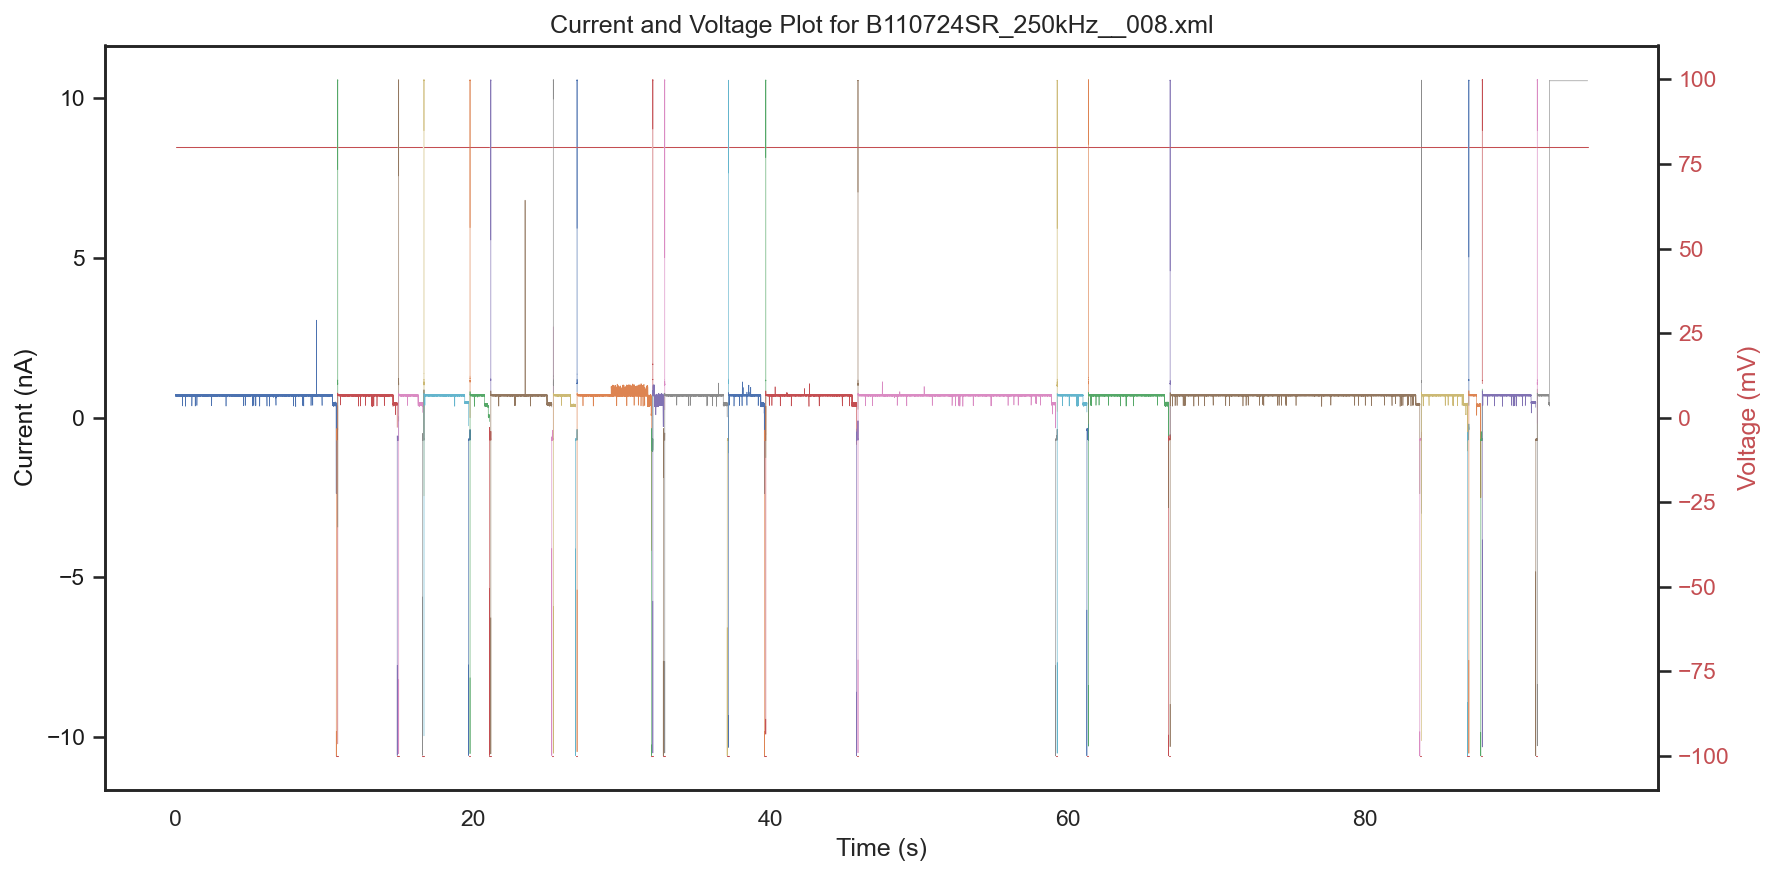

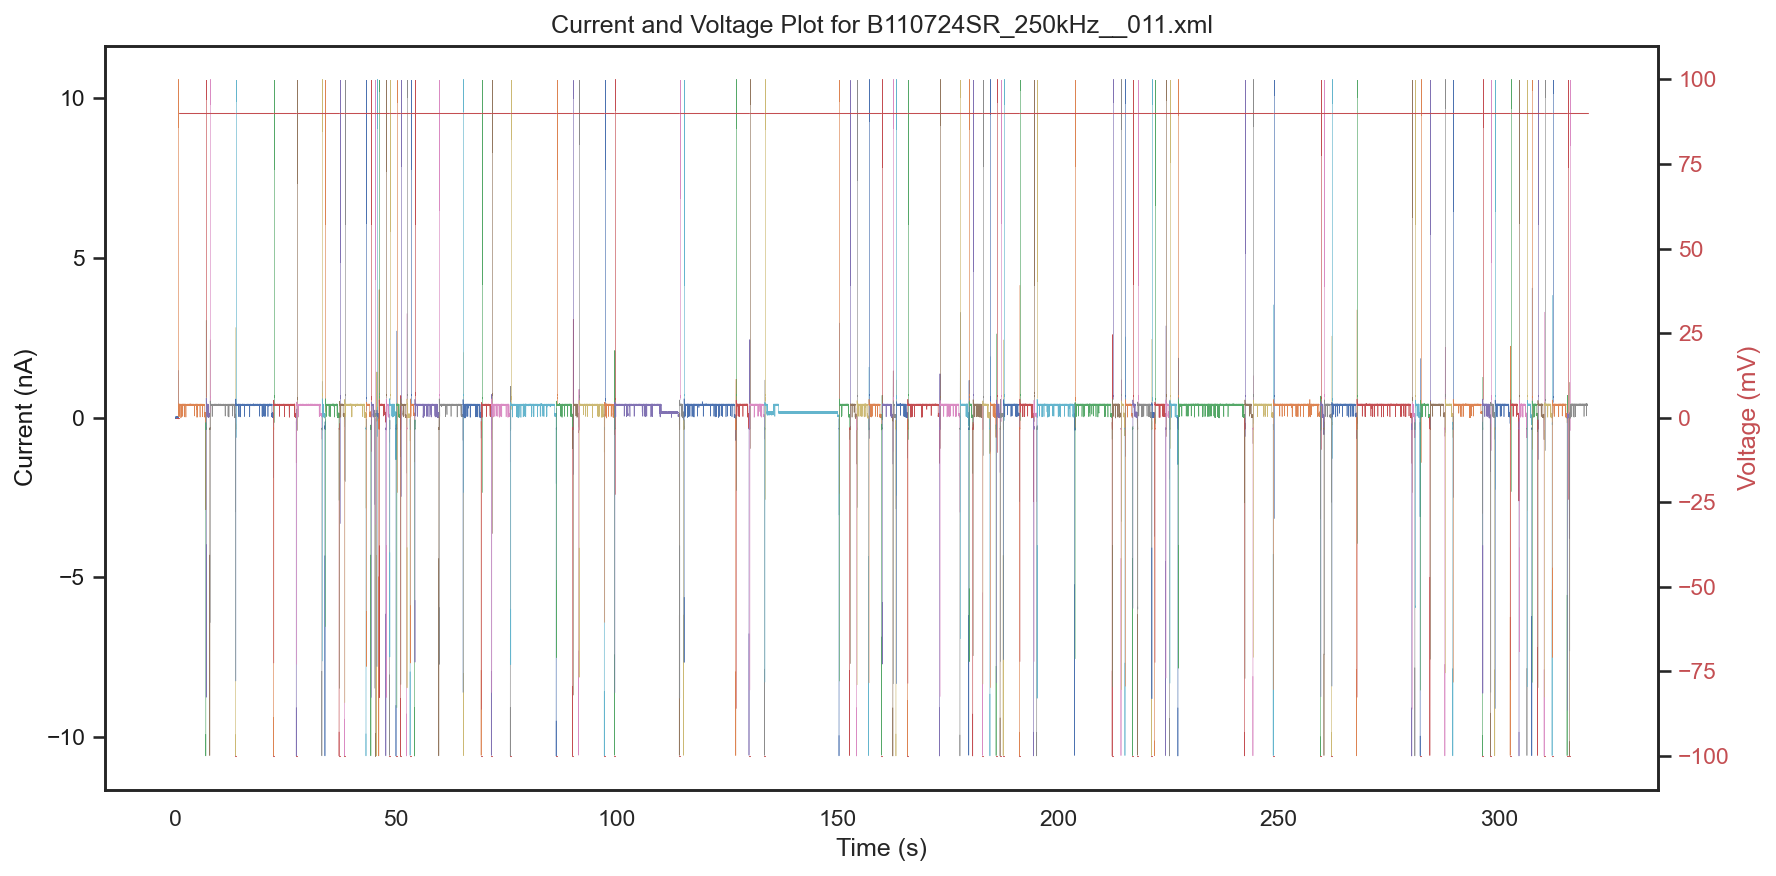

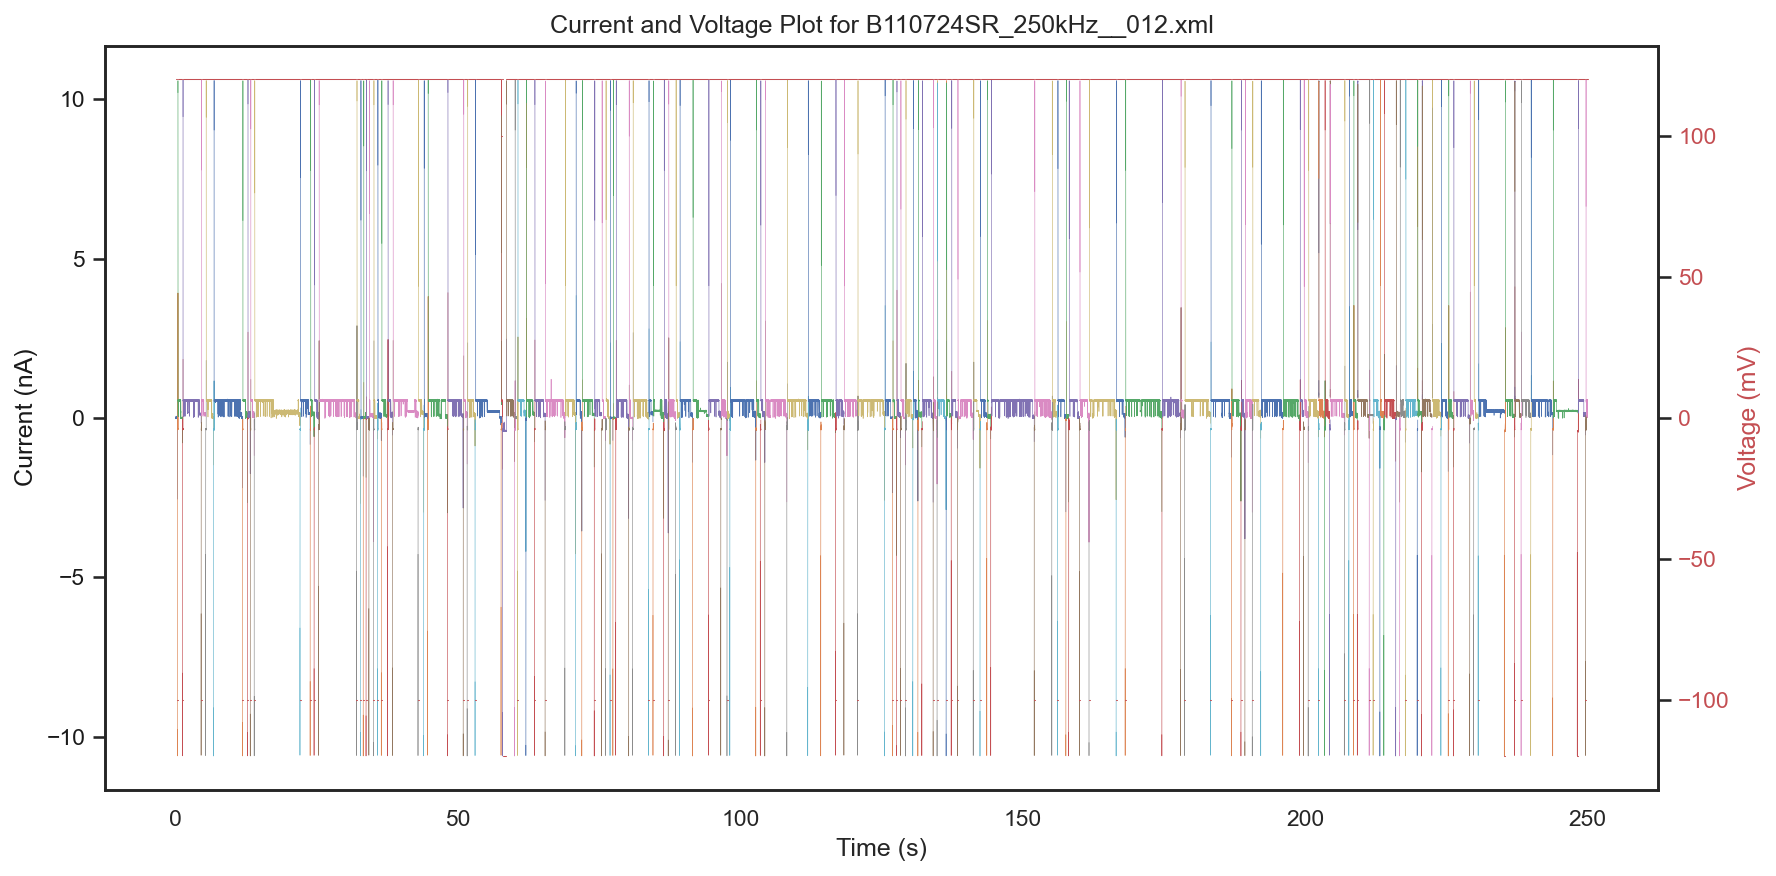

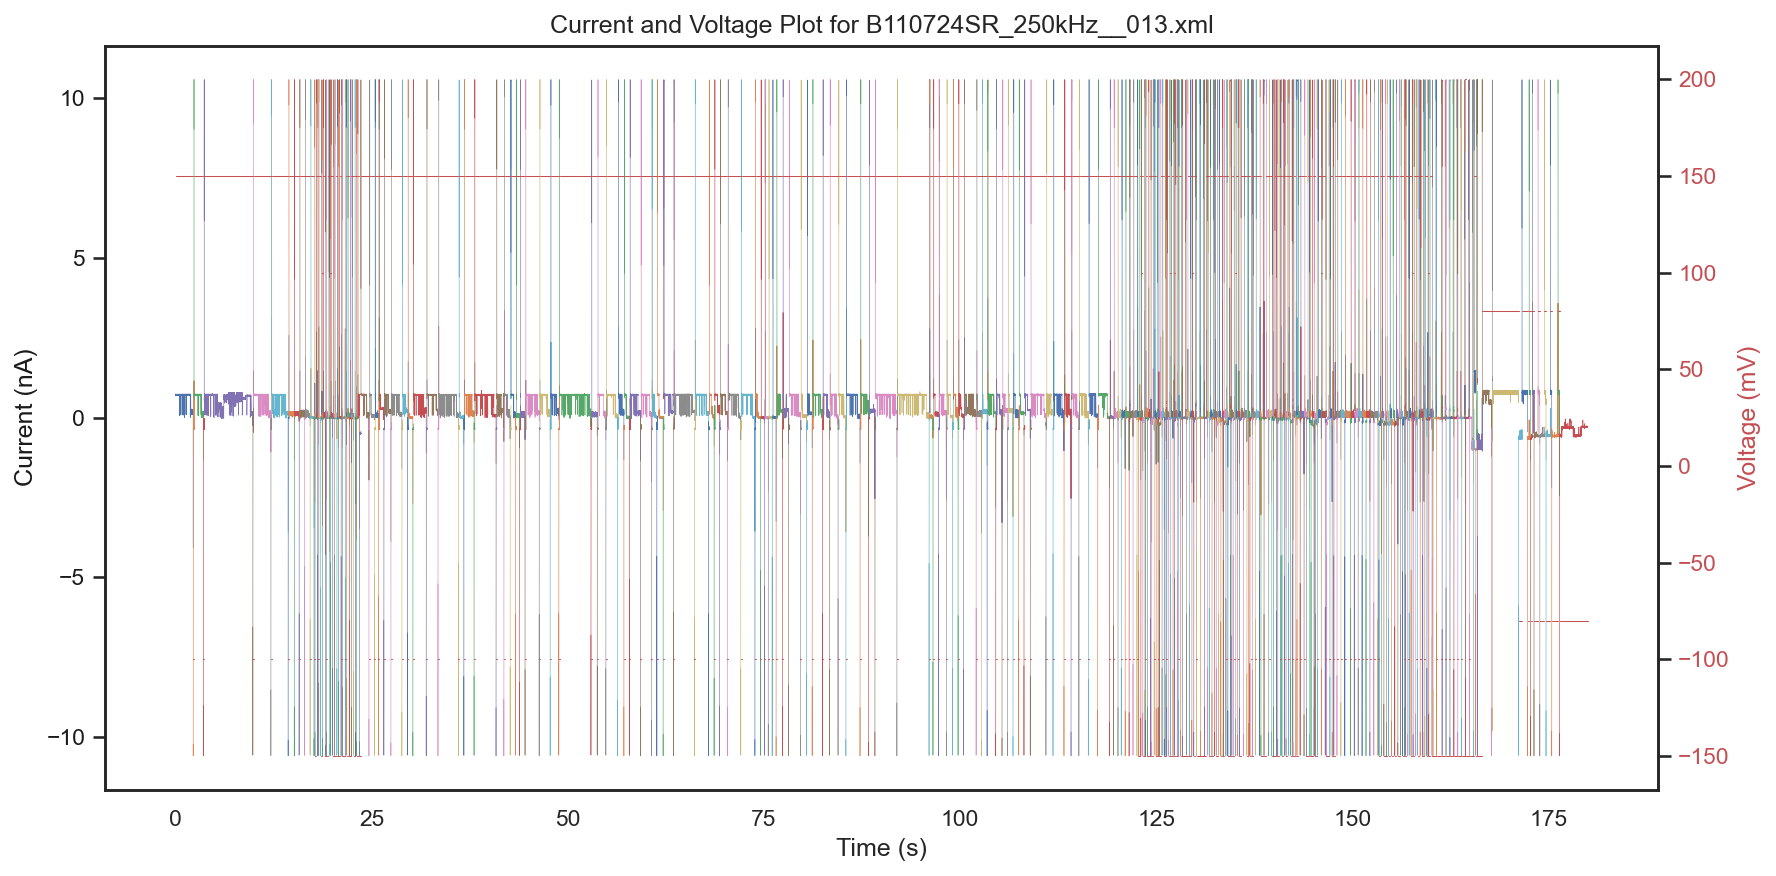

In [18]:
%matplotlib inline
for i, tf in enumerate(sfm.children):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2=ax1.twinx()
    for child in tf.traverse_to_rank("vstep"):
        ax1.plot(child.time, child.current, lw=0.3, label='Current')
        ax2.plot([child.time[0],child.time[-1]], [child.unique_features['voltage']]*2, lw=0.5, c='r')
        file_name = tf.get_feature("metadata")["HeaderFile"].split("/")[-1]
        plt.title(f"Current and Voltage Plot for {file_name}")
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Current (nA)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax2.set_ylabel('Voltage (mV)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.tight_layout()
    plt.show()


# Start event parser

/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__004.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__006.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 1/B110724SR_250kHz__003.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__008.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__011.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__012.xml


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/dinaraboyko/grad_school/cloned_repo/data/xialin/file 2/B110724SR_250kHz__013.xml


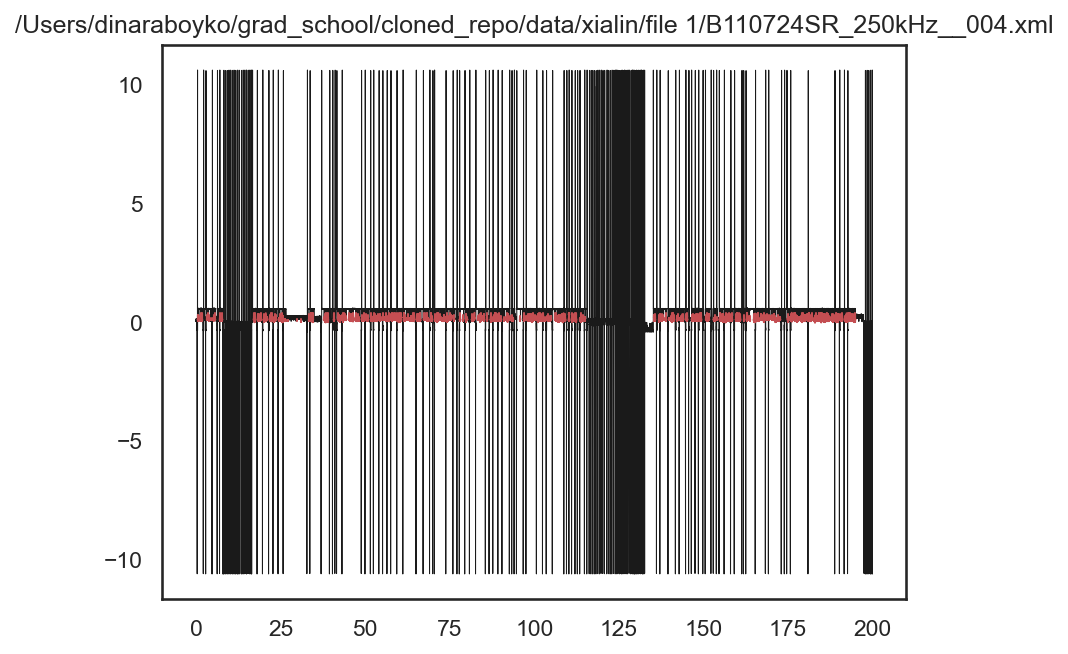

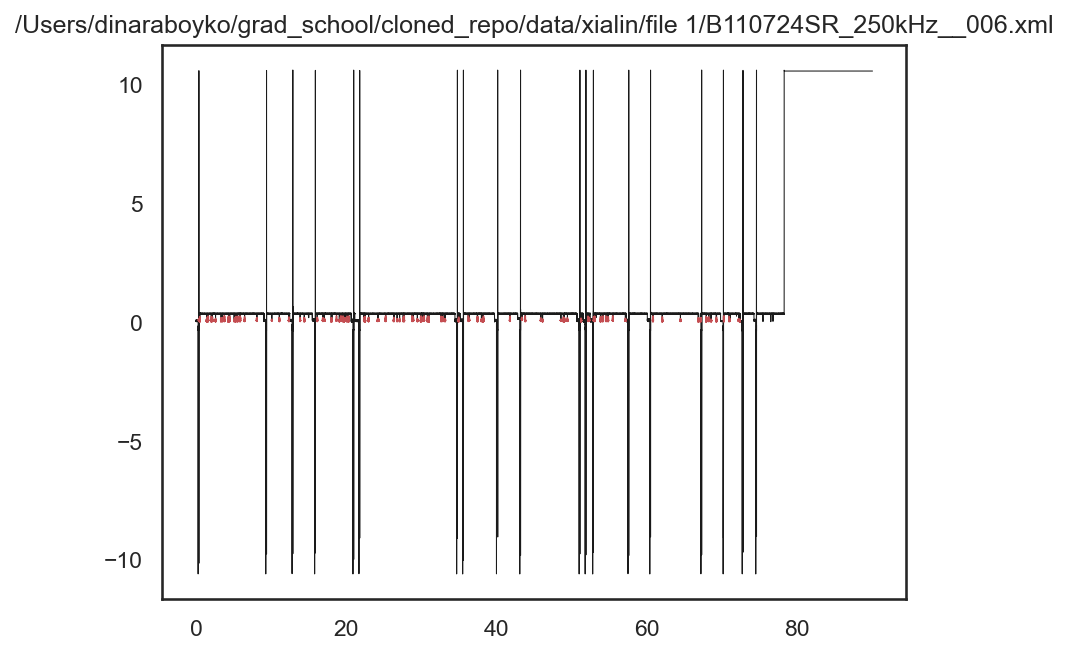

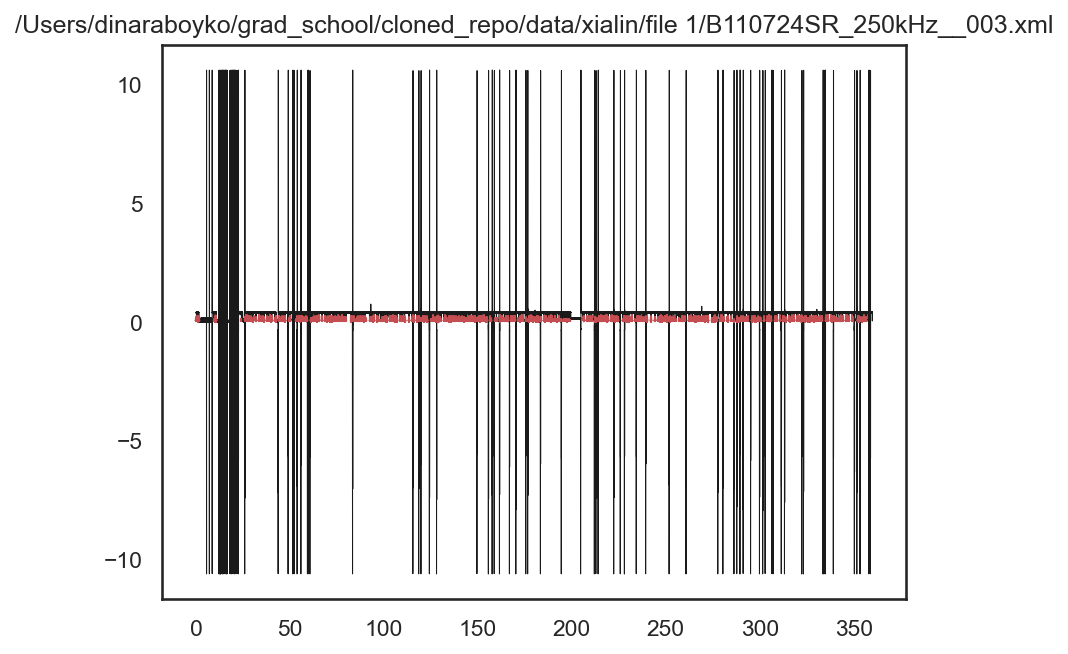

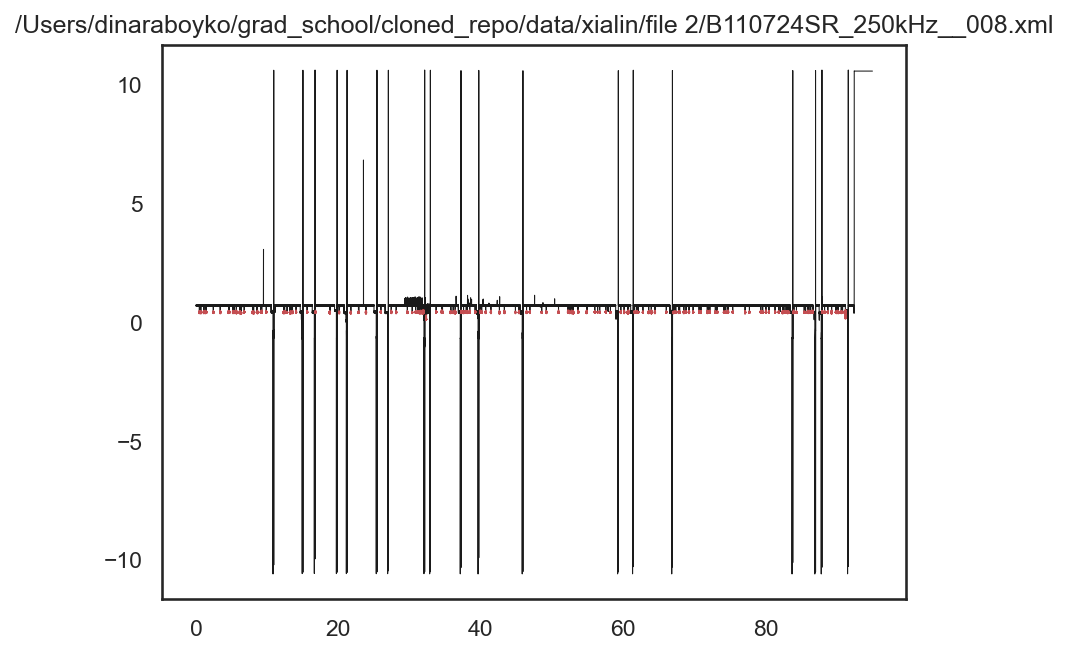

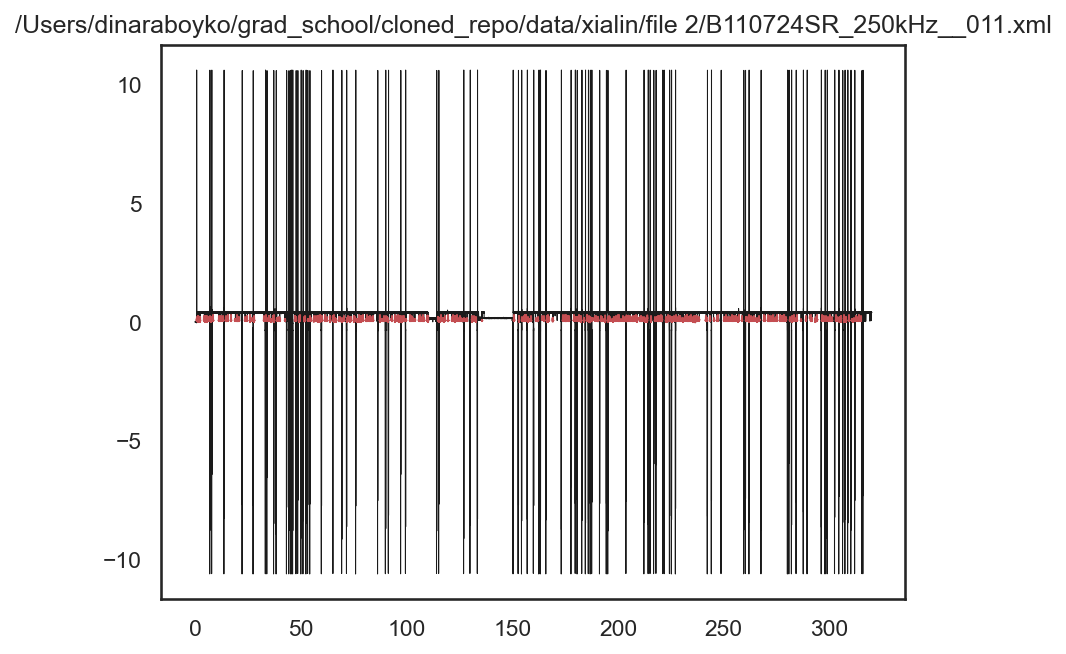

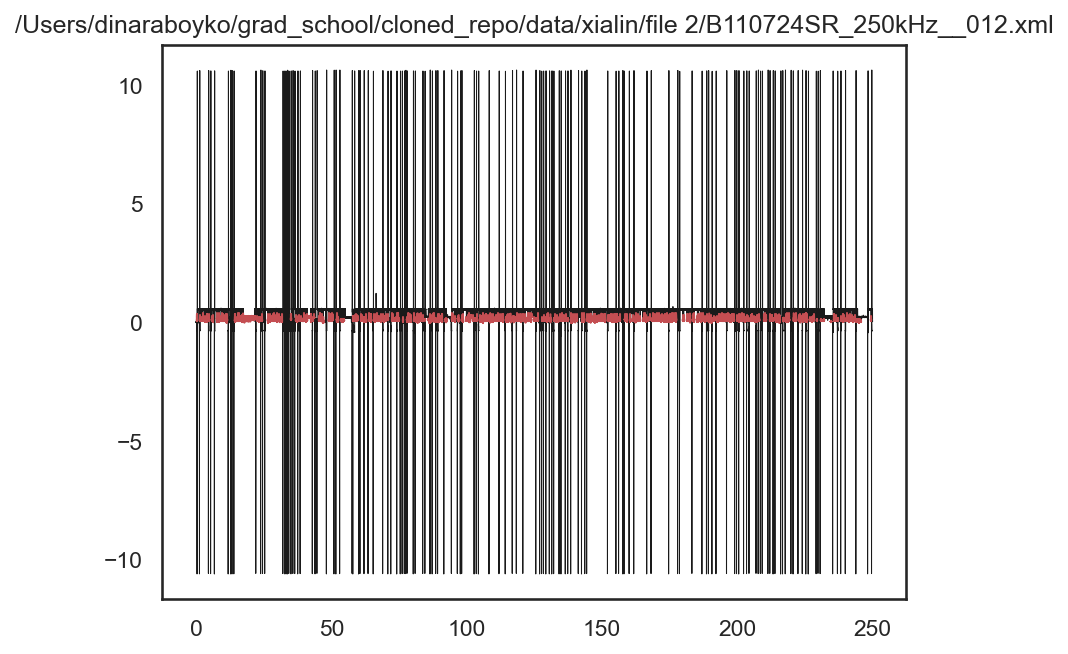

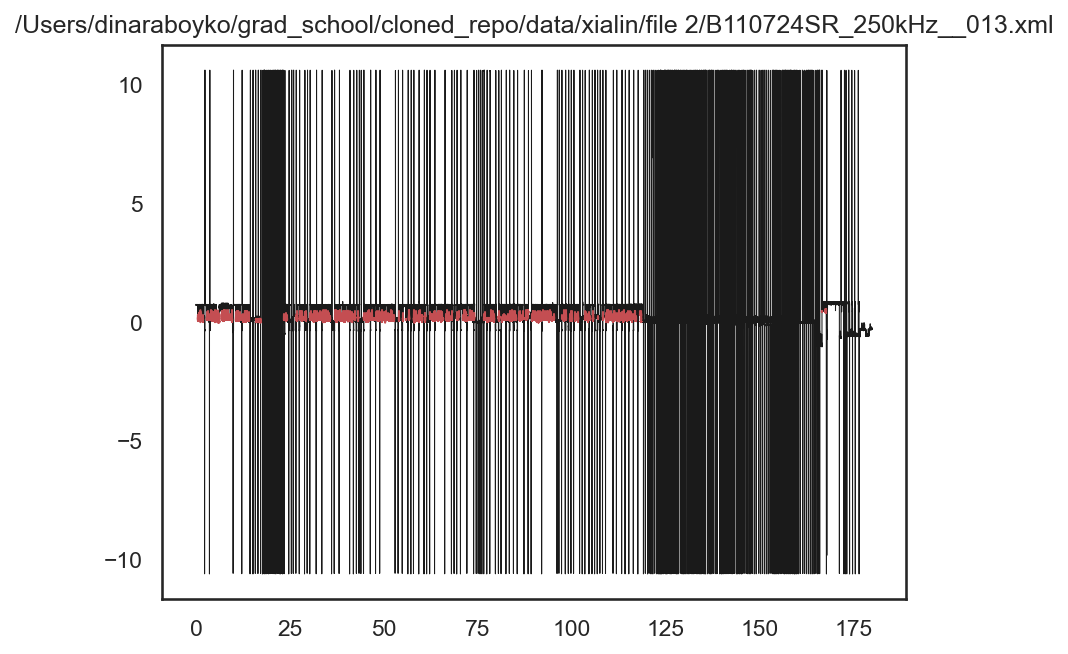

In [19]:
import numpy.ma as ma
from ioniq.parsers import lambda_event_parser
plt.close('all')
color_map={80.0:"tab:grey",60:"tab:blue",150:"tab:green",90:"tab:orange",120.0:"tab:red",100:"tab:purple"}
def parse(tf,starts=None,ends=None,voltage_range=(0.149,0.251),threshold=0.7):
    if starts is None:
        starts=[tf.time[0]]
    if ends is None:
        ends=[tf.time[-1]]
    
    steps=set()
    # print(len(tf.traverse_to_rank("vstepgap")))
    for step in tf.traverse_to_rank("vstepgap"):
        for start,end in zip(starts,ends):
            # print(step.get_feature('voltage'))
            if start<step.time[0] and step.time[-1]<end and voltage_range[0]<=step.get_feature("voltage")<=voltage_range[1]:
                steps.add(step)
    if len(steps)==0:
        return
    steps=list(steps)
    # plt.figure()
    ti=0
    results=[]
    for step in steps:
        # plt.plot(step.t,step.current,c='k',lw=0.4)
        mask=np.where(step.current>100e-3,1,0)
        masked_current=ma.masked_array(step.current,mask)
        
        hist,edges=np.histogram(masked_current,bins=150,range=(50e-3,900e-3))
        centers=edges[:-1]+(edges[1]-edges[0])*0.5
        I0guess=centers[np.argmax(hist)]
        Ithresh=I0guess*threshold
        # print(I0guess)
        if I0guess<150e-3:
            continue
        eventmask=np.where(step.current<Ithresh,1,0)
        # print(eventmask)
        lambda_parser=lambda_event_parser(threshold=Ithresh,rules=[lambda event:0<event.mean<I0guess*0.6,lambda event:event.duration>4])
        
        events=lambda_parser.parse(step.current)
        if len(events)==0:
            continue
        for i in range(len(events)):
            
            if i==len(events)-1:
                bstart=events[i].start+events[i].duration
                bend=step.current.shape[0]
                
            else:
                bstart=events[i].start+events[i].duration
                bend=events[i+1].start
                # baseline=step.current[events[i].start+events[i].duration:events[i+1].start]
            baseline=step.current[bstart:bend]
            events[i].I0=np.median(baseline,axis=-1)
            if events[i].I0<0.5e-10:
                print(baseline*1e9,bstart,bend)
                # event.I0=np.median(step.current[])
        # print(len(events))
        if events[-1].start+events[-1].duration==step.current.shape[0]:
            events.pop(-1)     
        if len(events)==0:
            continue  
        if events[0].start==0:
            events.pop(0)   
        for event in events:
            event.parent=step
            wstart=max(event.start-50,0)
            wend=min(event.start+event.duration+50,step.current.shape[0])
            # print(wstart,wend)
            event.wrap=step.current[wstart:wend]   
            
        for event in events:
            event.duration=1/250000*event.current.shape[0]
            event.voltage=step.get_feature("voltage")
            # if np.log10(event.duration)>-4:
            #     continue
            t=np.arange(event.current.shape[0])/250000+ti
            # plt.plot(t,event.current,lw=0.4)
            # # plt.plot(t,[I0guess]*t.shape[0])
            ti+=event.duration+0.005
        
        # color=color_map[round(float(step.get_feature("voltage")),3)]
        results+=events
        
    plt.figure()
    plt.title(tf.metadata["HeaderFile"])
    plt.plot(tf.time[::],tf.current[::],lw=0.5,c='k')
    for event in results:
        # print(event.parent.start)
        # print(event.start)
        t=np.arange(event.current.shape[0])/50000+event.start/50000+event.parent.time[0]
        
        plt.plot(t,event.current,lw=1,c='r')
    
        # plt.scatter([I0guess]*len(events),[np.log10(event.duration) for event in events],c=color,s=4)
        # print([np.mean([np.log10(event.duration) for event in events],axis=-1)])
        # plt.scatter([I0guess],[np.median([np.log10(event.duration) for event in events],axis=-1)],marker="*",s=10,c='r')
        # plt.hist2d([I0guess]*len(events),[np.log10(event.duration) for event in events],range=[ [1e-10,5e-10],[-3.5,1]],bins=(40,20),norm='log')
        # plt.scatter([np.log10(event.duration) for event in events],[1-event.mean/event.I0 for event in events],c=color,s=4)
        
    # plt.xlim(0.6,1)
    # plt.ylim(-4,1)
        # plt.plot(centers,hist)
        
    return results
dfs={}
for tf in sfm.children: 
    events=parse(tf,voltage_range=(50,150)) 
    key=tf.metadata["HeaderFile"]
    print(key)
    rootfolder=os.path.split(key)[0]
    dfs[key]=pd.DataFrame(columns=['mean','frac','dwell','baseline','Voltage','current','wrap','rootfolder'])
    for event in events:
        dfdict={"mean":event.mean,
                "frac":1-event.mean/event.I0,
                "dwell":event.duration,
                "baseline":event.I0,
                "Voltage":int(round(float(event.voltage),3)),
            "current":event.current,
            "wrap":event.wrap,
            "rootfolder":rootfolder}
        
        dfs[key].loc[len(dfs[key])]=dfdict

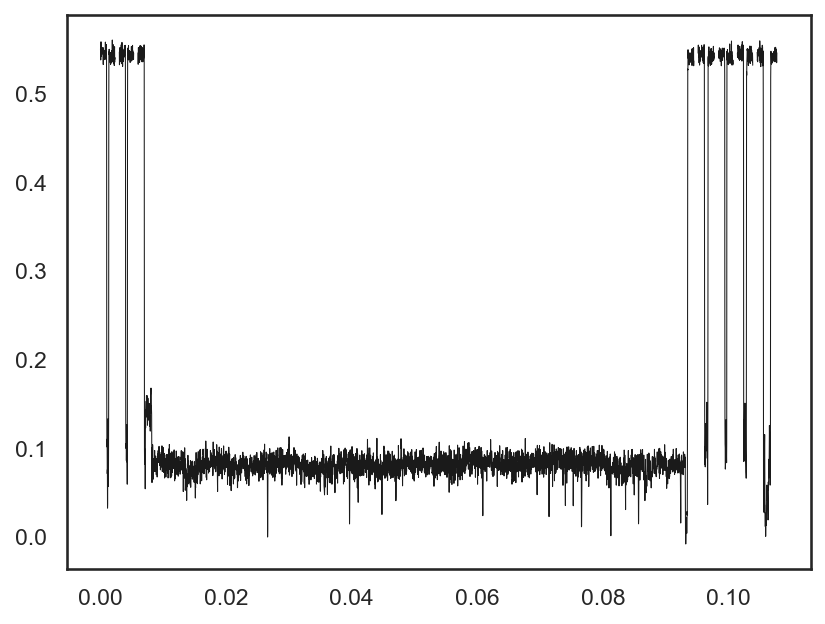

In [20]:
_dff=list(dfs.values())[0].iloc[128:135]
plt.figure()

toffset=0
gap=0.0007
sampling_freq=50000
for idx, row in _dff.iterrows():
    t=np.arange(row.wrap.shape[0])/sampling_freq+toffset
    plt.plot(t,row.wrap,lw=0.5,c='k')

    toffset=t[-1]+gap

# Features. Combined by experiment

['120' '80' '90']


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout can

['80' '90' '120' '150']


/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/dinaraboyko/grad_school/cloned_repo/ioniq/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


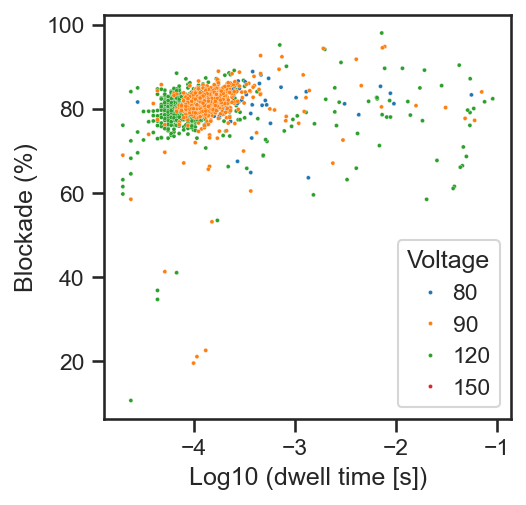

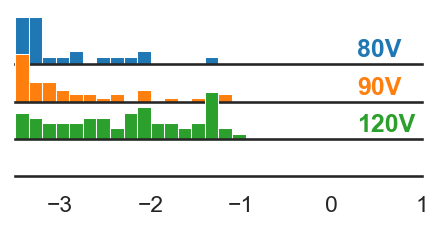

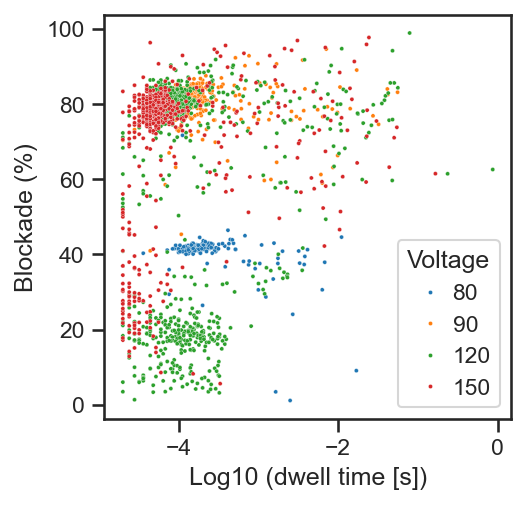

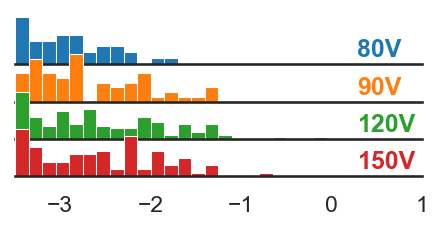

In [21]:
%matplotlib inline
import matplotlib as mpl
plt.close('all')
hueorder=[80,90,120,150]
hueorder=list(map(str,hueorder))
mpl.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.family"]=["Arial"]
plt.rcParams["ps.useafm"] = True
plt.rcParams["figure.dpi"]=150


masterdf=pd.concat([_df for _df in dfs.values()])
for groupname,df in masterdf.groupby("rootfolder"):
    # sns.set_theme("white")
    
    sns.set_style("ticks")
    df["logdwell"]=np.log10(df["dwell"])
    df["fracpct"]=np.multiply(df["frac"],100)
    df["voltagestr"]=df["Voltage"].astype(str)
    print(df["voltagestr"].unique())
    plt.figure(figsize=(3.5,3.5))
    palette=sns.color_palette("tab10", 4)
    ax=sns.scatterplot(df,x="logdwell",y='fracpct',hue='voltagestr',palette=palette,hue_order=hueorder,s=4)
    # ax=sns.scatterplot(df,x="baseline",y='fracpct',hue='voltagestr',palette=palette,hue_order=hueorder,s=6)
    handles,labels=ax.get_legend_handles_labels()
    
    sns.move_legend(ax,loc="lower right",title="Voltage",handles=handles,labels=[str(x)+" mV" if x in df["voltagestr"].unique() else "_" for x in labels ],handletextpad=0)
    # plt.ylim(70,100)
    # plt.xlim(-3.5,1)
    plt.ylabel("Blockade (%)")
    plt.xlabel("Log10 (dwell time [s])")
    # plt.savefig(f"{key}_scatter.pdf")
    
    
    
    sns.set_theme(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
    binrange=[-3.5,1]
    binwidth=0.15
    bin_count=int((binrange[1]-binrange[0])/binwidth)
    # g = sns.FacetGrid(_df, row="Voltage (V)",row_order=hueorder, hue="Voltage (V)", hue_order=hueorder, aspect=8, height=.5,sharey=False,sharex=True, palette='rainbow',xlim=binrange)
    # g.map(sns.histplot, "frac",
    #   binwidth=binwidth,binrange=binrange, clip_on=True,
    #   fill=True, alpha=1, linewidth=0.45,common_norm=True,log_scale=(False,True))
    # plt.figure()
    
    g = sns.FacetGrid(df, row="voltagestr",row_order=hueorder, hue="voltagestr", hue_order=hueorder, 
                      aspect=10, height=.35,sharey=False,sharex=True, palette=palette,xlim=binrange)
    g.map(sns.histplot, "logdwell",
      binwidth=binwidth,binrange=binrange, clip_on=True,
      fill=True, alpha=1, linewidth=0.5,common_norm=True,hue_norm=(150,225))
    g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.84, .28, label+"V", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    g.map(label,'logdwell')
    g.figure.subplots_adjust(hspace=-0.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="",xlabel="")
    g.despine( left=True)
    # g.figure.savefig(f"{key}_dwell_hist.pdf")
    # print(g.axes.shape)
    # g.axes[3,0].tick_params(axis='x',reset=True,top=False)
    # g.refline(y=0.8, linewidth=0.4, linestyle="-", color=None, clip_on=False)
    